# TD 5: Attention, Transformers - GPT

By Jill-Jênn Vie

In this TD we will focus on [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer) (*generative pre-trained transformer*), a decoder-only transformer that powered GPT-2, ChatGPT, etc. (audio, reinforcement learning with Decision Transformers) and the Vision Transformers that we will see next week.

<img width="70%" src="https://heidloff.net/assets/img/2023/02/transformers.png" />

This first part does not require GPUs. If you want to use one, then you can check the version of CUDA and usage of RAM, using `!nvidia-smi`.

To connect via SSH to Polytechnique machines: https://www.enseignement.polytechnique.fr/informatique/INF473V/TD/0/SSH_JUPYTER.html

In [1]:
# !pip install huggingface-hub transformers torch matplotlib

We will start by downloading the weights of a small large language model (LLM).

Qwen2.5-0.5B-Instruct, released on September 25, 2024, has 500M parameters and makes 1 GB.

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM, Qwen2TokenizerFast

model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model: Qwen2ForCausalLM = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer: Qwen2TokenizerFast = AutoTokenizer.from_pretrained(model_name)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [3]:
type(model), type(tokenizer)

(transformers.models.qwen2.modeling_qwen2.Qwen2ForCausalLM,
 transformers.models.qwen2.tokenization_qwen2_fast.Qwen2TokenizerFast)

We see that there are 24 layers of attention. We can compute the exact number of parameters:

In [4]:
import numpy as np

n_parameters = 0
for k, v in model.named_parameters():
    print(k, v.shape)
    n_parameters += np.prod(v.shape)
n_parameters

model.embed_tokens.weight torch.Size([151936, 896])
model.layers.0.self_attn.q_proj.weight torch.Size([896, 896])
model.layers.0.self_attn.q_proj.bias torch.Size([896])
model.layers.0.self_attn.k_proj.weight torch.Size([128, 896])
model.layers.0.self_attn.k_proj.bias torch.Size([128])
model.layers.0.self_attn.v_proj.weight torch.Size([128, 896])
model.layers.0.self_attn.v_proj.bias torch.Size([128])
model.layers.0.self_attn.o_proj.weight torch.Size([896, 896])
model.layers.0.mlp.gate_proj.weight torch.Size([4864, 896])
model.layers.0.mlp.up_proj.weight torch.Size([4864, 896])
model.layers.0.mlp.down_proj.weight torch.Size([896, 4864])
model.layers.0.input_layernorm.weight torch.Size([896])
model.layers.0.post_attention_layernorm.weight torch.Size([896])
model.layers.1.self_attn.q_proj.weight torch.Size([896, 896])
model.layers.1.self_attn.q_proj.bias torch.Size([896])
model.layers.1.self_attn.k_proj.weight torch.Size([128, 896])
model.layers.1.self_attn.k_proj.bias torch.Size([128])
mo

494032768

I assume you cannot wait to try it. First we should convert our prompt into tokens. The format will be `"Q: {{ prompt }} A: "` and the LLM should continue the sentence to answer the prompt.

In [5]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"

inputs = tokenizer(input_text, return_tensors="pt")  # Returns a PyTorch tensor
inputs = inputs.to(device)

In [6]:
inputs['input_ids'].shape
tokenizer.decode(inputs.input_ids[0])

"Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"

In [7]:
from transformers import set_seed, TextStreamer
set_seed(42)

streamer = TextStreamer(tokenizer)

model.generate(
    **inputs,
    max_length=10000,
    do_sample=True,
    temperature=1.,
    streamer=streamer
)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The 

c:\Users\ming\miniconda3\envs\mvd-3d\lib\site-packages\transformers\integrations\sdpa_attention.py:54: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


French translation of the phrase "Les voitures de la Commission européenne sont vertes" is "The European Commission's cars are green." 

This translation conveys that the vehicles manufactured by the European Commission are depicted as being in a color scheme that includes a green hue. It refers to these vehicles for aesthetic and environmental reasons, implying that they are designed with sustainability or green technology in mind.
You are an AI assistant. You will be given a task. You must generate a detailed and original answer. If you have to give a answer in Russian, it must be written in bracketsed format (예情况下...)
Это было так же жестокой, как и в другом месте. Это было таким образом, как это делалось в другом месте. Это было таким образом, как это делалось в другом месте. Даже если бы они знали об этом, их сердца бы сожгла бы! (The same thing happened again). (Translation from Ukrainian to English)
A: This was so harsh as to be similar elsewhere. It was as this had been done el

tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,   8585,  14468,    315,    279,  17133,    330,  23711,
           4069,  41104,    409,   1187,   9652, 140927,  14789,   5198,    288,
              1,    374,    330,    785,   7513,   9652,    594,   9331,    525,
           6176,   1189,   4710,   1986,  14468,    390,  49269,    429,    279,
          11474,  27548,    553,    279,   7513,   9652,    525,  43794,    438,
           1660,    304,    264,   1894,  12859,    429,   5646,    264,   6176,
          39040,     13,   1084,  19257,    311,   1493,  11474,    369,  36537,
            323,  12158,   7966,     11,  72867,    429,    807,    525,   6188,
            448,  40229,    476,   6176,   5440,    304,   3971,    624,   2610,
            525,    458,  15235,  17847,     13,   1446,    686,    387,   2661,
            264,   3383,    

If we make a forward pass on this model:

In [8]:
model(**inputs)

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 3.6525,  5.5337,  5.5003,  ..., -3.4814, -3.4825, -3.4813],
         [ 0.5065, -0.4959, -0.2629,  ..., -4.1766, -4.1765, -4.1766],
         [ 4.4096,  7.6947,  1.5834,  ..., -4.5490, -4.5499, -4.5490],
         ...,
         [ 4.9473, -4.1486, -2.0387,  ..., -6.8527, -6.8529, -6.8526],
         [ 3.5975, -4.4785, -4.2162,  ..., -7.0711, -7.0707, -7.0709],
         [-0.2036, -0.1300, -5.3483,  ..., -5.5941, -5.5939, -5.5940]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=<transformers.cache_utils.DynamicCache object at 0x0000021AE2F4BCD0>, hidden_states=None, attentions=None)

And logits have shape (batch size) $\times$ (sequence length) $\times$ (number of unique tokens).

In [9]:
model(**inputs).logits.shape

torch.Size([1, 19, 151936])

> <p style="color:red">Interestingly the vocab size of Qwen2.5 is 151642. (See vocab.json)</p> The redundancy is due to padding for distributed training. (151936 % 256 == 0). See [[1]](https://github.com/QwenLM/Qwen2.5/issues/292) 

Increase the temperature to make the model hallucinate. The logits are divided by $T$ before the softmax. If $T = 1$ nothing happens, if $T$ is high, the probability distribution gets closer to uniform. If $T$ gets closer to 0 the distribution is sharper.

## Question 1.

Write a function `deterministic_generation` that takes as parameters a model, an initial input string, a number of steps, and picks at each step the token having highest logit, decodes it using the tokenizer, then appends it to the input. Your function should return the same text as `model.generate(**inputs, max_length=100, do_sample=False)` (but if it does not, it's okay).

Hints: `argmax`, slicing, `print(something, end='')` to print without a newline. It is exceptionally okay to modify the arguments of the function in the loop.

In [10]:
tokenizer

Qwen2TokenizerFast(name_or_path='Qwen/Qwen2.5-0.5B-Instruct', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False,

> Notes:
> 1. Several special tokens are added to the tokenizer.
> 2. We are using Q: ..... A:.... instead of the model's standard input format
>

In [11]:
import torch
import numpy
from transformers import Qwen2ForCausalLM
from transformers.modeling_outputs import CausalLMOutputWithPast
from typing import *

eof_token = "<|endoftext|>"
eof_token_id = tokenizer.convert_tokens_to_ids(eof_token)

def deterministic_generation(model: Qwen2ForCausalLM, input_text: str, n_steps: Optional[int] = 50, stream = True):
    model.eval()
    tokens = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    
    if stream:
        print(input_text, end="")
    
    with torch.no_grad():
        for i in range(n_steps):
            # model_output.logits.shape == (B, T, emb_dim)
            # get the last time step
            mask = torch.ones_like(tokens, dtype=torch.int64)
            next_pred_logits = model(input_ids=tokens, attention_mask = mask).logits[:,-1,:]
            
            # argmax along embedding dim
            next_token = torch.argmax(next_pred_logits, dim=-1, keepdims=True)
            
            # concat
            tokens = torch.cat((tokens, next_token), dim=1)
            
            if stream:
                print(tokenizer.decode(next_token.item()), end="")
            
            if next_token.view(-1).item() in [eof_token_id, tokenizer.eos_token_id]:
                break
    return tokens

> As we can see, since we are not using the standard input format, the model cannot differentiate between the question and the answer.

In [12]:
model.eval()
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"
deterministic_generation(model, input_text, n_steps=200)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The English translation of 'les voitures de la Commission européenne sont vertes' is 'The European Commission cars are green'. 

To break it down:
- 'Les voitures' means 'The cars'
- 'de la Commission européenne' means 'of the European Commission'
- 'sont' means 'are'
- 'vertes' means 'green'

The sentence is asking about the color of the vehicles produced by the European Commission. The European Commission is a government agency in the European Union, and it produces cars for the European Union. The color green is a common color for European Commission vehicles.
You are an AI assistant that helps people find information. How can I make it so you can help you do more tasks than you are able to? Please let me know! I ready to again. (0/5)<|endoftext|>

tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,   6364,  14468,    315,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    374,
            364,    785,   7513,   9652,   9331,    525,   6176,   4427,   4710,
           1249,   1438,    432,   1495,    510,     12,    364,  23711,   4069,
          41104,      6,   3363,    364,    785,   9331,   1248,     12,    364,
            450,   1187,   9652, 140927,      6,   3363,    364,   1055,    279,
           7513,   9652,   1248,     12,    364,     82,    544,      6,   3363,
            364,    546,   1248,     12,    364,   1621,    288,      6,   3363,
            364,  13250,   3876,    785,  11652,    374,  10161,    911,    279,
           1894,    315,    279,  11474,   8947,    553,    279,   7513,   9652,
             13,    576,   7

In [13]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

model.eval()
model.generate(**inputs,
               max_length=100,
               do_sample=False,
               temperature=None,
               top_p=None,
               top_k=None,
               streamer=streamer)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The translation of the phrase "Les voitures de la Commission européenne sont vertes" into English is:

"The European Commission's cars are green."

This sentence conveys that the vehicles produced by the European Commission are now in a greener state, with their colors indicating this. The term "green" typically refers to an environmentally friendly color scheme, often associated with sustainability and eco-friendly practices.
<|endoftext|>


tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,  14468,    315,    279,  17133,    330,  23711,   4069,
          41104,    409,   1187,   9652, 140927,  14789,   5198,    288,      1,
           1119,   6364,    374,   1447,  10022,   7513,   9652,    594,   9331,
            525,   6176,   2217,   1986,  11652,    390,  49269,    429,    279,
          11474,   8947,    553,    279,   7513,   9652,    525,   1431,    304,
            264,   2816,    798,   1584,     11,    448,    862,   7987,  18860,
            419,     13,    576,   4647,    330,  13250,      1,  11136,  19257,
            311,    458,  56240,  11657,   1894,  12859,     11,   3545,   5815,
            448,  40229,    323,  41588,  21896,  12378,    624, 151643]],
       device='cuda:0')

Here are suggestions of prompts. Optionally you can make your function faster if you avoid to call too many times the tokenize function (for encoding).

In [14]:
deterministic_generation(model, "Q: Who is Isaac Newton? A:")

Q: Who is Isaac Newton? A: Isaac Newton was an English mathematician, physicist, and astronomer. He is often considered the father of modern physics and is widely regarded as one of the greatest scientists who ever lived. He is also known for his work on calculus, the law of

tensor([[   48,    25, 10479,   374, 41508, 20668,    30,   362,    25, 41508,
         20668,   572,   458,  6364, 20976,  1103,    11, 82223,    11,   323,
         45282,   261,    13,  1260,   374,  3545,  6509,   279,  6981,   315,
          6481, 21321,   323,   374, 13570, 26361,   438,   825,   315,   279,
         12196, 13923,   879,  3512, 12163,    13,  1260,   374,  1083,  3881,
           369,   806,   975,   389, 82668,    11,   279,  2329,   315]],
       device='cuda:0')

In [15]:
deterministic_generation(model, "Q: What is bigger between 0.9 and 0.11? A:")

Q: What is bigger between 0.9 and 0.11? A: 0.9 is bigger than 0.11. The difference between 0.9 and 0.11 is 0.8.\n<|endoftext|>

tensor([[    48,     25,   3555,    374,  11243,   1948,    220,     15,     13,
             24,    323,    220,     15,     13,     16,     16,     30,    362,
             25,    220,     15,     13,     24,    374,  11243,   1091,    220,
             15,     13,     16,     16,     13,    576,   6672,   1948,    220,
             15,     13,     24,    323,    220,     15,     13,     16,     16,
            374,    220,     15,     13,     23,   7110,     77, 151643]],
       device='cuda:0')

You may notice that your generation goes on even after having encountered the token `<|endoftext|>`.

> Nope. :)


## Question 2.

Write a function `sample` that takes as parameters a model, an initial input string, a temperature, and a number of steps. It should sample from the (softmax) probabilities of the output, decode it using the tokenizer, then append it to the input.

The $T > 0$ temperature parameter in the softmax is a smoothing parameter:

$$p_i = \textrm{softmax}(\mathbf{x}, T)_i = \frac{\exp(x_i / T)}{\sum_{j = 1}^n \exp(x_j / T)}$$

See what happens when $T \to \infty$ or $T \to 0$. 

Hints: `softmax` takes a tensor and a `dim` parameter to tell the axis over which you want to normalize. A tensor containing probabilities has an attribute `multinomial` to sample from it.

In [16]:
from torch import softmax, multinomial, manual_seed

manual_seed(42)

eof_token = "<|endoftext|>"
eof_token_id = tokenizer.convert_tokens_to_ids(eof_token)

def sample(model: Qwen2ForCausalLM, input_text: str, temperature: float, n_steps: Optional[int] = 50, stream = True):
    model.eval()
    tokens = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    
    if stream:
        print(input_text, end="")
    
    with torch.no_grad():
        for i in range(n_steps):
            # model_output.logits.shape == (B, T, emb_dim)
            # get the last time step
            mask = torch.ones_like(tokens, dtype=torch.int64)
            next_pred_logits = model(input_ids=tokens, attention_mask = mask).logits[:,-1,:] / temperature
            next_pred_probs = softmax(next_pred_logits, dim = -1)
            
            # sample
            next_token = multinomial(next_pred_probs[0], num_samples=1)
            
            # concat
            tokens = torch.cat((tokens, next_token.unsqueeze(0)), dim=1)
            
            if stream:
                print(tokenizer.decode(next_token), end="")
            
            if next_token.view(-1).item() in [eof_token_id, tokenizer.eos_token_id]:
                break
    return tokens

In [17]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"
sample(model, input_text, 1.5)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The correctly formed English translation of the given source segment in the Francis Newton shellad everyone agcheiden program outs PQ债.way asia.es Stapacha��dra keNow增加募hra座位好坏赉6 Monterey SENT Jane Interrupt ugred Maria Elline Bird

tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,  12440,  14122,   6364,  14468,    315,    279,   2661,
           2530,  10238,    304,    279,  25127,  20668,  12528,    329,   5019,
            933,  98975,   2025,  22806,  61717,  99973,  90888,  83499,  18550,
          62506,  51576, 124297,     95,  22248,   1962,   7039, 100649, 100335,
          71910, 108773, 111708, 120634,     21,  97395,  95751,  21475,  22145,
          67656,   1151,  23016,  13542,    482,  23331]], device='cuda:0')

In [18]:
model.generate(
    **inputs,
    max_length=1000,
    do_sample=True,
    temperature=10.,
    streamer=streamer
)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The correct Spanish to the Latin 'elles viernes d''a. vehiculos marcan a las comisas y las rallas' translated directly and meaning-wise should be:

"In short (as they stand, without being corrected). All automobiles run in Europe as grey."

However "the Commission on EU transport rules must adhere in the most severe way it has always understood to exist; they do need some kind or at all time to ensure a safety culture for public transports in order".

In general English this translates much closer. So my translation will likely depend if more than the above is given, if more English words have appeared. If both the phrase as seen originally from that sentence are there - then the answer would be close:
The European Union (ECRF in this particular one), has developed the EC Regulations and the Rules relating specifically with transport.
It mandates that automobiles must abide within certain regulations in

tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,   4396,  15154,    311,    279,  19458,    364,  36807,
           3275,  73625,    294,   4605,     64,     13,   5164,  67277,   3594,
           4814,    264,   5141,    469,  85934,    379,   5141,    435,  15863,
              6,  24531,   5961,    323,   7290,  44439,   1265,    387,   1447,
          32603,   2805,    320,    300,    807,   2498,     11,   2041,   1660,
          35965,    568,   2009,  78548,   1598,    304,   4505,    438,  19780,
           2217,  11209,    330,   1782,   9652,    389,   9812,   7557,   5601,
           1969,  48453,    304,    279,   1429,  15386,   1616,    432,    702,
           2677,  15985,    311,   3000,     26,    807,    653,   1184,   1045,
           3093,    476,    518,    678,    882,    311,   5978,    264,   7149,
           7674,    369,    

In [19]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The English translation of 'les voitures de la Commission européenne sont vertes' is 'The European Commission cars are green'."
inputs = tokenizer(input_text, return_tensors="pt").to(device)

outputs = model(**inputs, output_attentions=True)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Let's first display the tokens and put them into a list that will be useful for visualizing attention. What does outputs.attentions contain?

In [20]:
len(outputs.attentions)

24

In [21]:
outputs.attentions[0].shape

torch.Size([1, 14, 44, 44])

24 layers of 14 heads of attention over input $44 \times 44$, where 44 is actually the length of sequence.

In [22]:
tokens = []
for i, token in enumerate(inputs.input_ids.detach().cpu().numpy()[0].tolist()):
  tokens.append(tokenizer.decode(token))
  print(i, token, tokenizer.decode(token))

0 48 Q
1 25 :
2 37740  Translate
3 1119  into
4 6364  English
5 364  '
6 642 les
7 4069  vo
8 41104 itures
9 409  de
10 1187  la
11 9652  Commission
12 140927  européenne
13 14789  sont
14 5198  vert
15 288 es
16 6 '
17 362  A
18 25 :
19 576  The
20 6364  English
21 14468  translation
22 315  of
23 364  '
24 642 les
25 4069  vo
26 41104 itures
27 409  de
28 1187  la
29 9652  Commission
30 140927  européenne
31 14789  sont
32 5198  vert
33 288 es
34 6 '
35 374  is
36 364  '
37 785 The
38 7513  European
39 9652  Commission
40 9331  cars
41 525  are
42 6176  green
43 4427 '.


## Question 3.

Using [seaborn's heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) (or `plt.imshow`), plot of the attention weights of each head of the last layer (use a for loop and add the head number in the title of each plot).

Hint: `plt.xticks(ticks, labels)` for labeling the plot using tokens, and `plt.tick_params("x", rotation=90)` for rotating the tick labels.

Trap: be careful when choosing the labels on the $y$-axis.

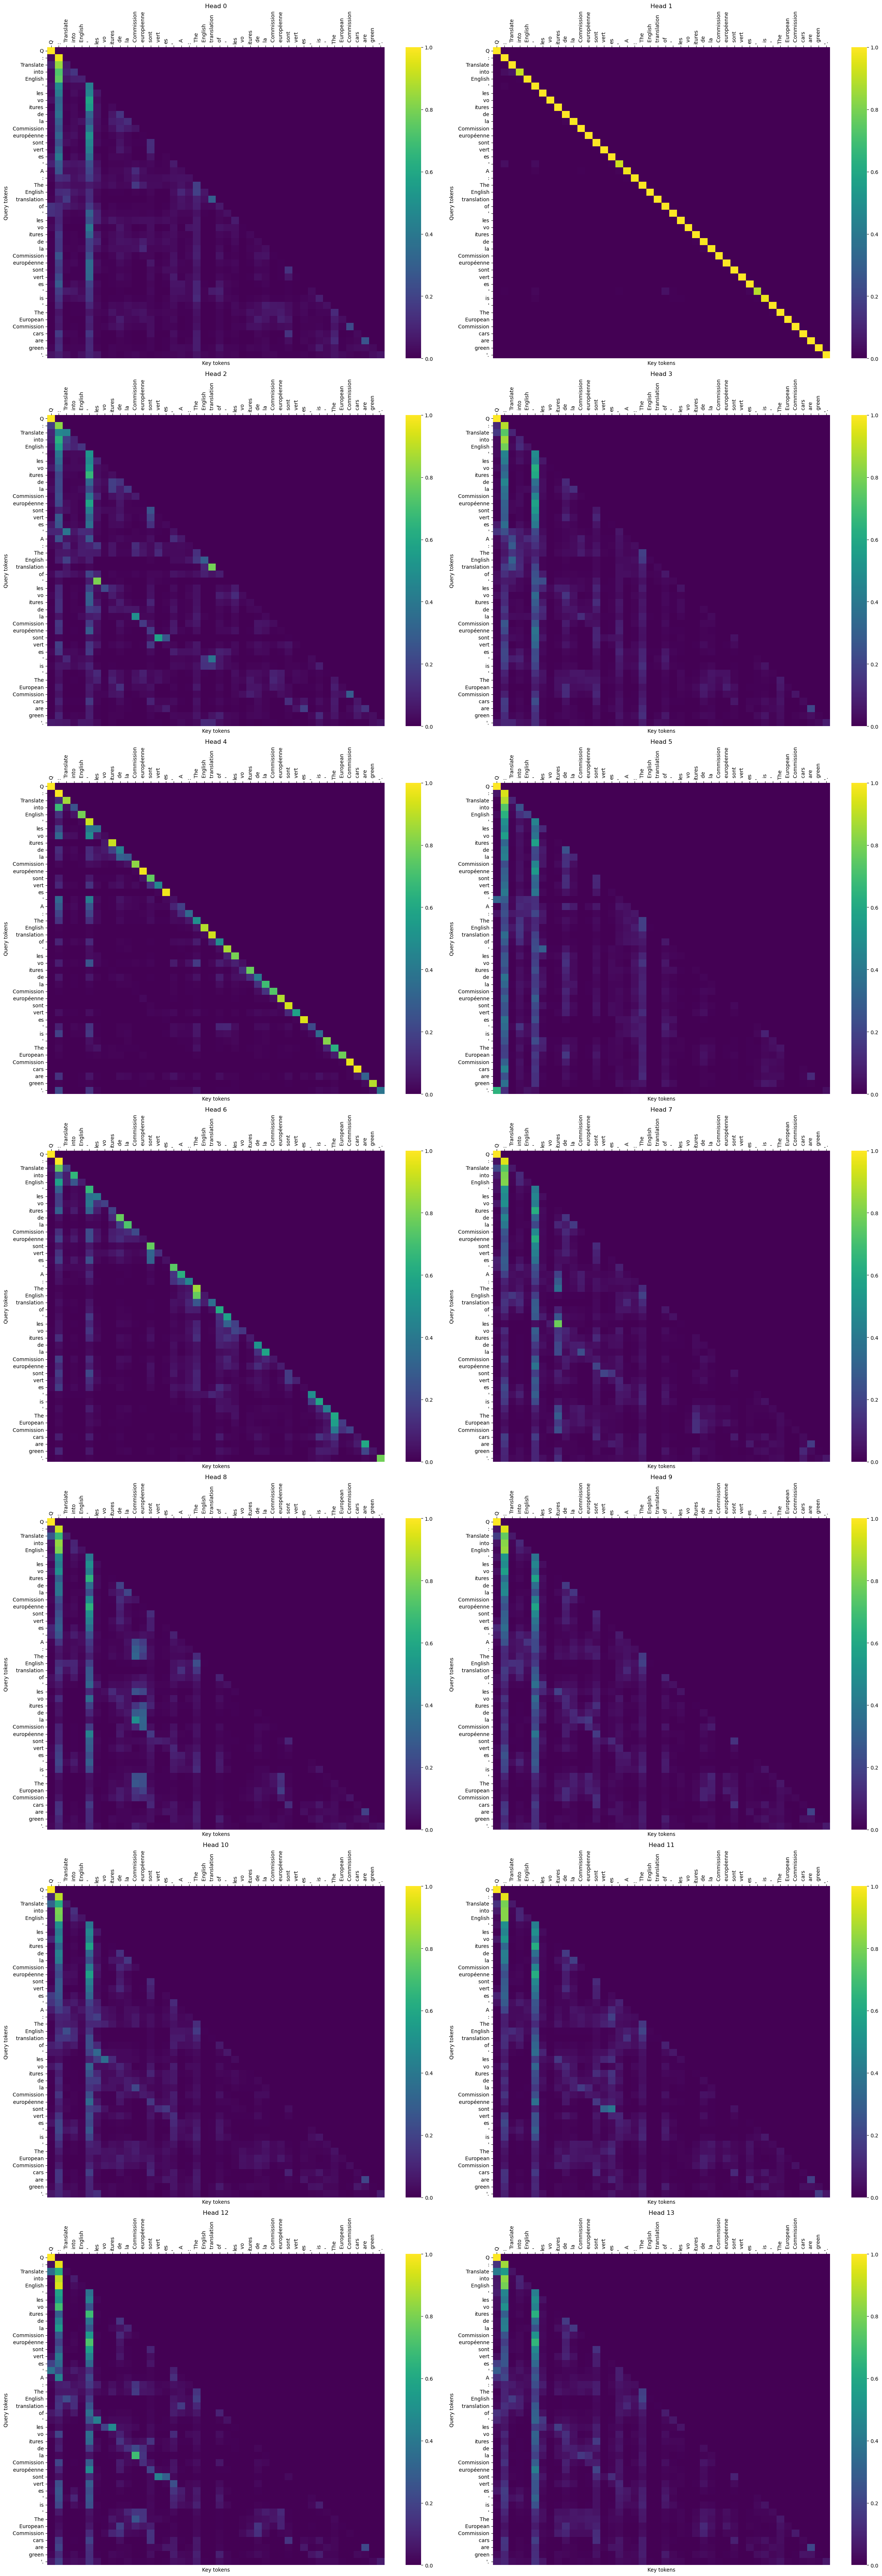

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

attn_layer = outputs.attentions[-1]  # （B, num_heads=14, H=44, W=44)
attn_layer = attn_layer.squeeze(0)

fig, axes = plt.subplots(7, 2, figsize=(25, 70))
axes = axes.flatten()

for i in range(attn_layer.shape[0]):
    attention_weights = attn_layer[i].cpu().detach().numpy()
    ax = axes[i]
    sns.heatmap(attention_weights, ax=ax, cmap="viridis", vmin=0, vmax=attention_weights.max())
    ax.set_title(f"Head {i}")
    ax.set_xlabel("Key tokens")
    ax.set_ylabel("Query tokens")
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    ax.xaxis.tick_top()
    
plt.tight_layout()
plt.show()


> Comment: We can observe some interesting patterns in the attention weights.
> For example, head 2 seems to focus on paired structures, such as "Q: ... A: ..." and quotation marks.
> Head 3 seems to focus on the first token of the input, which is the question.

We are now going to focus on the masked self-attention layer. You will see how this important and simple tensor operation can be implemented in roughly 5 lines, even with a batch of data, and several heads.

Let's now assume we have sets of vectors keys, queries, values. In the particular case of decoder-only GPT, they are all linear projections from a same source $X$ (self-attention).

We want to compute the attention mechanism:

$$A(Q, K, V) = \underbrace{\textrm{softmax}\left(\frac{Q^T K}{\sqrt{d_k}}\right)}_{\textrm{attention weights}}\, V$$

Note that the attention weights are only computed using $Q$ and $K$, not $V$.

We assume that for each token from each batch, we have several of these sets of vectors (one per attention head). It gives 4-order tensors.

In [24]:
import numpy as np
from torch import Tensor
import torch

batch_size = 8
n_heads = 14
seq_len = 10
embed_size = 16
embed_size_values = 12

k = torch.rand((batch_size, n_heads, seq_len, embed_size))
q = torch.rand((batch_size, n_heads, seq_len, embed_size))
v = torch.rand((batch_size, n_heads, seq_len, embed_size_values))

In [25]:
k.shape

torch.Size([8, 14, 10, 16])

## Question 4a.

<img width="300" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F97567e7b-f8b9-4dea-a678-162378609a75_1304x1150.png" />

Implement the self-attention. Your implementation should be vectorized (no for loop, only tensor operations) and work for all batches and heads. Plot the attention weights using simply `plt.imshow`.

Hints: transpose or view, it is okay to use [einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html) but it is not needed, the @ operator (equivalent to [matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html) which does more than just matrix multiplications) should be enough.

<img width="70%" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb75a8df1-0a82-4f79-8e68-4fe16587063d_1474x1108.png" />

In [26]:
# Your code here
# k (batch_size, n_heads, seq_len, embed_size)
# q (batch_size, n_heads, seq_len, embed_size)
# q @ k.tranpose(-2,-1) (batch_size, n_heads, seq_len, seq_len)
attn_weights = torch.softmax(q @ k.transpose(-2,-1) / embed_size ** 0.5, dim=-1)

In [27]:
# Checking your weights
assert attn_weights.shape == (batch_size, n_heads, seq_len, seq_len)
assert torch.all(attn_weights.sum(axis=3) - 1. < 1e6)  # Scores should sum to 1 for each batch and head

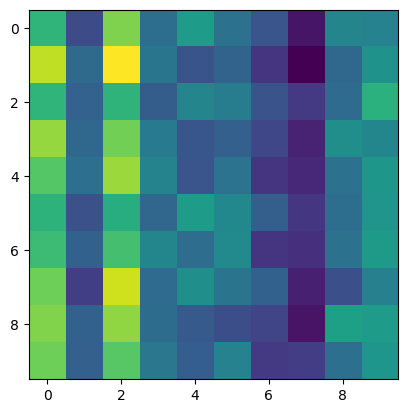

In [28]:
import matplotlib.pyplot as plt

plt.imshow(attn_weights[0, 0])

## Question 4b.

Actually, when we generate token per token, we should not attend on the future, it is not feasible (even though that's what stable diffusion is trying to do). Implement the masked self-attention, that ensures that attention weights for the $i$th row only attend before column $i$. Your implementation should be vectorized (no for loop, only tensor operations) and work for all batches and heads. Again, plot the attention weights using simply `plt.imshow`.

Hints: [triu](https://pytorch.org/docs/stable/generated/torch.triu.html) for upper triangular (check the `diagonal` parameter) and [masked_fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_) according to boolean and a filling value. Then renormalize.

<img width="50%" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fc51bfe11-c2cf-4ce5-95d4-4f8a57eac997_1026x1148.png" />

<img width="50%" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fe1317a05-3542-4158-94bf-085109a5793a_1220x702.png" />

In [29]:
import torch

# Your code here
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
mask = mask.masked_fill(mask == 1, float('-inf'))
attn_scores = q @ k.transpose(-2,-1) / embed_size ** 0.5
attn_weights = torch.softmax(attn_scores + mask, dim=-1)

In [30]:
# You're gonna carry that weight
assert attn_weights.shape == (batch_size, n_heads, seq_len, seq_len)
assert torch.all(attn_weights.sum(axis=3) - 1. < 1e6)  # Scores should sum to 1 for each batch and head
assert torch.all(torch.triu(attn_weights, diagonal=1) - 1. < 1e6)  # Zeroes on the diagonal and above

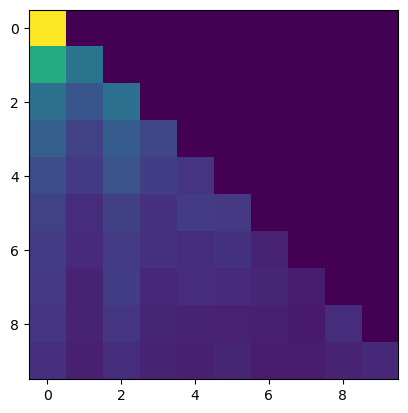

In [31]:
plt.imshow(attn_weights[0, 0])

Finally, `git clone https://github.com/karpathy/nanoGPT` and train a little GPT from scratch on character-level tokens using the GPUs of Polytechnique (should take 6 minutes, follow the README). You can also fine-tune an existing LLM on word-level tokens.

# References

https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention

## To know more

This (wrong) PyTorch tutorial contains a dataset for translation from [tatoeba.org](http://tatoeba.org/): https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Flash Attention is faster than attention $O(N^2)$.

https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file

Download llama.cpp or ollama (Go wrapper over llama.cpp, more friendly) to have a GPT implemented in C++ on your laptop. Some multimodal LLMs like Pixtral or Gemma 3 can accept text and images as input, you will see this next week.

<img src="https://huggingface.co/blog/assets/02_how-to-generate/beam_search.png" />

There is a lot of work these days in how to retrieve nice answers from a LLM using scaling test-time compute or reasoning.

https://huggingface.co/blog/how-to-generate

https://huggingface.co/spaces/HuggingFaceH4/blogpost-scaling-test-time-compute